<a href="https://colab.research.google.com/github/An-Dongsun/Section4---Project/blob/main/AI_13_%EC%95%88%EB%8F%99%EC%84%A0_Section4__project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3가지 폐렴 분류 모델**

- 9208개 파일
    - 정상 → 3270개
    - 폐렴-세균 → 3001개
    - 폐렴-바이러스 → 1656개
    - COVID-19 → 1281개

데이터 출처 : [kaggle : 3 kinds of Pneumonia](https://www.kaggle.com/datasets/artyomkolas/3-kinds-of-pneumonia)

In [16]:
# 필요할 라이브러리 불러오기
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import EfficientNetB7


from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model, Sequential

## 1. 데이터 불러오기

In [3]:
# 구글 드라이브와 연결한다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 시드를 고정한다.
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# 이미지 파일들 불러오기
Dataset_directory = '/content/drive/MyDrive/Curated X-Ray Dataset'

train = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory, # 경로 넣어주면 된다.
        labels = "inferred", # 레이블은 디렉토리 구조에서 생성됨
        label_mode = "int", # 레이블이 정수로 인코딩됨을 의미
        class_names = {'COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral'}, #레이블은 이미지 파일 경로의 영숫자 순서에 따라 정렬되어야 한다
        color_mode = "rgb", # "grayscale", "rgb", "rgba" 중 하나
        batch_size = 32, # 데이터 배치의 크기입니다. 기본값: 32
        image_size = (256, 256), # 디스크에서 읽은 후 이미지 크기를 조정할 크기
        shuffle = True, # 데이터를 섞을지 여부. False로 설정하면 데이터를 영숫자 순서로 정렬
        seed = 42, # 셔플 및 변환을 위한 선택적 임의 시드
        validation_split = 0.1, # 0과 1 사이의 선택적 부동 소수점, 유효성 검사를 위해 데이터의 일부 나누기
        subset = 'training', # "training", "validation" → validation_split가 설정된 경우에만 사용
        interpolation = "bilinear", # 문자열, 이미지 크기를 조정할 때 사용되는 보간 방법, bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, 를 지원
        follow_links = False, # 심볼릭 링크가 가리키는 하위 디렉토리를 방문할지 여부
        crop_to_aspect_ratio = False, # True이면 가로 세로 비율 왜곡 없이 이미지 크기를 조정
)

test = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory, # 경로 넣어주면 된다.
        labels = "inferred", # 레이블은 디렉토리 구조에서 생성됨
        label_mode = "int", # 레이블이 정수로 인코딩됨을 의미
        class_names = {'COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral'}, #레이블은 이미지 파일 경로의 영숫자 순서에 따라 정렬되어야 한다
        color_mode = "rgb", # "grayscale", "rgb", "rgba" 중 하나
        batch_size = 32, # 데이터 배치의 크기입니다. 기본값: 32
        image_size = (256, 256), # 디스크에서 읽은 후 이미지 크기를 조정할 크기
        shuffle = True, # 데이터를 섞을지 여부. False로 설정하면 데이터를 영숫자 순서로 정렬
        seed = 42, # 셔플 및 변환을 위한 선택적 임의 시드
        validation_split = 0.1, # 0과 1 사이의 선택적 부동 소수점, 유효성 검사를 위해 데이터의 일부 나누기
        subset = 'validation', # "training", "validation" → validation_split가 설정된 경우에만 사용
        interpolation = "bilinear", # 문자열, 이미지 크기를 조정할 때 사용되는 보간 방법, bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, 를 지원
        follow_links = False, # 심볼릭 링크가 가리키는 하위 디렉토리를 방문할지 여부
        crop_to_aspect_ratio = False, # True이면 가로 세로 비율 왜곡 없이 이미지 크기를 조정
)

Found 9208 files belonging to 4 classes.
Using 8288 files for training.
Found 9208 files belonging to 4 classes.
Using 920 files for validation.


## 2. ResNet50 전이학습

In [ ]:
# weights = 'imagenet' → 이미지넷을 학습한 파라미터를 가져온다.
# include_top → 모델의 뒷쪽인 분류망을 가져올지 결정하는 파라미터
resnet = ResNet50(weights = 'imagenet', include_top = False)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
# ResNet50 레이어들의 파라미터를 학습하지 않도록 설정
for layer in resnet.layers:
    layer.trainable = False # True = 내가 집어 넣어준 데이터에 맞게 추가 학습한다.

In [ ]:
# 모델에 출력층을 생성해준다.
x = resnet.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x) # 출력층을 설계한다.
model = Model(resnet.input, predictions)

In [ ]:
# 모델의 전체적인 형태 확인해보기
model.summary()

In [ ]:
# 모델 컴파일
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# 간단하게 5Epoch만 모델을 학습한다.
model.fit(train, validation_data = test, epochs = 5)

Epoch 1/5
259/259 [==============================] - 1600s 6s/step - loss: 0.6135 - accuracy: 0.7899 - val_loss: 0.3864 - val_accuracy: 0.8467
Epoch 2/5
259/259 [==============================] - 94s 354ms/step - loss: 0.3687 - accuracy: 0.8415 - val_loss: 0.3980 - val_accuracy: 0.8380
Epoch 3/5
259/259 [==============================] - 97s 363ms/step - loss: 0.3332 - accuracy: 0.8570 - val_loss: 0.3569 - val_accuracy: 0.8565
Epoch 4/5
259/259 [==============================] - 90s 338ms/step - loss: 0.3153 - accuracy: 0.8641 - val_loss: 0.3201 - val_accuracy: 0.8630
Epoch 5/5
259/259 [==============================] - 86s 322ms/step - loss: 0.2987 - accuracy: 0.8721 - val_loss: 0.3514 - val_accuracy: 0.8598


In [ ]:
# 검증 데이터셋 사용해서 결과 보기
model.evaluate(test, verbose = 1)

29/29 [==============================] - 9s 226ms/step - loss: 0.3514 - accuracy: 0.8598


[0.3514041006565094, 0.8597826361656189]

## 3. Early Stopping(조기 종료) 적용

In [ ]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath = "resnet50_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 5 → 연속적으로 5번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results = model.fit(train,
                    batch_size = batch_size,
                    epochs = epochs_max,
                    verbose = 1, 
                    validation_data = test,
                    callbacks = [early_stop, save_best])

Epoch 1/50
259/259 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.7985
Epoch 1: val_loss improved from inf to 0.38575, saving model to resnet50_best.hdf5
259/259 [==============================] - 146s 322ms/step - loss: 0.5702 - accuracy: 0.7985 - val_loss: 0.3857 - val_accuracy: 0.8391
Epoch 2/50
259/259 [==============================] - ETA: 0s - loss: 0.3605 - accuracy: 0.8457
Epoch 2: val_loss did not improve from 0.38575
259/259 [==============================] - 83s 313ms/step - loss: 0.3605 - accuracy: 0.8457 - val_loss: 0.3968 - val_accuracy: 0.8511
Epoch 3/50
259/259 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.8527
Epoch 3: val_loss improved from 0.38575 to 0.32867, saving model to resnet50_best.hdf5
259/259 [==============================] - 84s 316ms/step - loss: 0.3374 - accuracy: 0.8527 - val_loss: 0.3287 - val_accuracy: 0.8663
Epoch 4/50
259/259 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.8

### 3-1) 학습된 모델을 이용하여 테스트

In [ ]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = model.evaluate(test, verbose = 1)

29/29 [==============================] - 9s 230ms/step - loss: 0.3721 - accuracy: 0.8457


### 3-2) best model을 이용한 테스트

In [ ]:
model.load_weights(checkpoint_filepath)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = model.evaluate(test, verbose = 1)

29/29 [==============================] - 9s 246ms/step - loss: 0.3287 - accuracy: 0.8663


## Restnet50 전이학습
  * 분류기 정교하게 구성

In [ ]:
# weights = 'imagenet' → 이미지넷을 학습한 파라미터를 가져온다.
# include_top → 모델의 뒷쪽인 분류망을 가져올지 결정하는 파라미터
resnet = ResNet50(weights = 'imagenet', include_top = False)

In [ ]:
# ResNet50 레이어들의 파라미터를 학습하지 않도록 설정
for layer in resnet.layers:
    layer.trainable = False # True = 내가 집어 넣어준 데이터에 맞게 추가 학습한다.

In [ ]:
# 모델에 출력층을 생성해준다.
x = resnet.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x) # 출력층을 설계한다.
resnet_model2 = Model(resnet.input, predictions)

In [ ]:
# 모델의 전체적인 형태 확인해보기
resnet_model2.summary()

In [ ]:
# 모델 컴파일
resnet_model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath2 = "resnet_model2_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath2,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results = resnet_model2.fit(train,
                            batch_size = batch_size,
                            epochs = epochs_max,
                            verbose = 1, 
                            validation_data = test,
                            callbacks = [early_stop, save_best])

Epoch 1/50
259/259 [==============================] - ETA: 0s - loss: 0.5020 - accuracy: 0.7989
Epoch 1: val_loss improved from inf to 0.36182, saving model to resnet_model2_best.hdf5
259/259 [==============================] - 102s 374ms/step - loss: 0.5020 - accuracy: 0.7989 - val_loss: 0.3618 - val_accuracy: 0.8543
Epoch 2/50
259/259 [==============================] - ETA: 0s - loss: 0.3757 - accuracy: 0.8380
Epoch 2: val_loss did not improve from 0.36182
259/259 [==============================] - 91s 341ms/step - loss: 0.3757 - accuracy: 0.8380 - val_loss: 0.3681 - val_accuracy: 0.8565
Epoch 3/50
259/259 [==============================] - ETA: 0s - loss: 0.3567 - accuracy: 0.8425
Epoch 3: val_loss did not improve from 0.36182
259/259 [==============================] - 89s 336ms/step - loss: 0.3567 - accuracy: 0.8425 - val_loss: 0.3650 - val_accuracy: 0.8554
Epoch 4/50
259/259 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.8634
Epoch 4: val_loss did not impro

###4-1) 학습된 모델을 이용하여 테스트

In [ ]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = resnet_model2.evaluate(test, verbose = 1)

29/29 [==============================] - 9s 228ms/step - loss: 0.4231 - accuracy: 0.8533


###4-2) resnet_model2_best을 이용한 테스트

In [ ]:
resnet_model2.load_weights(checkpoint_filepath2)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = resnet_model2.evaluate(test, verbose = 1)

29/29 [==============================] - 9s 226ms/step - loss: 0.3175 - accuracy: 0.8652


##5. InceptionResNetV2 이용한 전이학습

### 5-1) 파라미터 학습 가능

In [ ]:
inception_resnet = tf.keras.applications.InceptionResNetV2(
                              include_top = False,
                              weights = "imagenet",
                              input_tensor = None,
                              input_shape = (256, 256, 3),
                              )

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
# InceptionResNetV2 레이어들의 파라미터를 새로운 데이터에 맞게 학습하도록 설정
for layer in inception_resnet.layers:
    layer.trainable = True # True = 내가 집어 넣어준 데이터에 맞게 추가 학습한다.

In [ ]:
# 모델에 출력층을 생성해준다.
x = inception_resnet.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x) # 출력층을 설계한다.
inception_resnet_model = Model(inception_resnet.input, predictions)

In [ ]:
inception_resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# 모델 컴파일
inception_resnet_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath3 = "inception_resnet_model_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath3,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results3 = inception_resnet_model.fit(train,
                                      batch_size = batch_size,
                                      epochs = epochs_max,
                                      verbose = 1,
                                      validation_data = test,
                                      callbacks = [early_stop, save_best])

Epoch 1/50
259/259 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.7924
Epoch 1: val_loss improved from inf to 1.68521, saving model to inception_resnet_model_best.hdf5
259/259 [==============================] - 223s 774ms/step - loss: 0.5152 - accuracy: 0.7924 - val_loss: 1.6852 - val_accuracy: 0.6728
Epoch 2/50
259/259 [==============================] - ETA: 0s - loss: 0.3930 - accuracy: 0.8392
Epoch 2: val_loss improved from 1.68521 to 1.52801, saving model to inception_resnet_model_best.hdf5
259/259 [==============================] - 201s 763ms/step - loss: 0.3930 - accuracy: 0.8392 - val_loss: 1.5280 - val_accuracy: 0.8022
Epoch 3/50
259/259 [==============================] - ETA: 0s - loss: 0.3364 - accuracy: 0.8588
Epoch 3: val_loss improved from 1.52801 to 0.85621, saving model to inception_resnet_model_best.hdf5
259/259 [==============================] - 203s 770ms/step - loss: 0.3364 - accuracy: 0.8588 - val_loss: 0.8562 - val_accuracy: 0.8130
Epoch 4/

In [ ]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = inception_resnet_model.evaluate(test, verbose = 1)

29/29 [==============================] - 10s 280ms/step - loss: 0.4688 - accuracy: 0.8717


In [ ]:
inception_resnet_model.load_weights(checkpoint_filepath3)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = inception_resnet_model.evaluate(test, verbose = 1)

29/29 [==============================] - 10s 277ms/step - loss: 0.3073 - accuracy: 0.8880


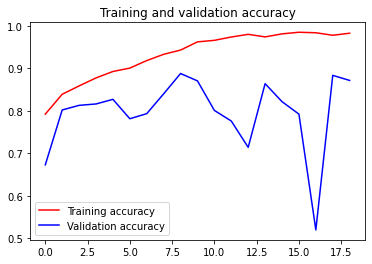

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = results3.history['accuracy']
val_acc = results3.history['val_accuracy']
loss = results3.history['loss']
val_loss = results3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

## 6. EfficientNetB7

### 6-1) 분류기의 파라미터 학습

In [ ]:
EfficientNetB7 = tf.keras.applications.EfficientNetB7(
                              include_top = False,
                              weights = "imagenet",
                              input_tensor = None,
                              input_shape = (256, 256, 3),
                              )

258088960/258076736 [==============================] - 1s 0us/step


In [ ]:
# EfficientNetB7 레이어들의 파라미터를 학습하지 않도록 설정
for layer in EfficientNetB7.layers:
    layer.trainable = False # True = 내가 집어 넣어준 데이터에 맞게 추가 학습한다.

In [ ]:
# 모델에 출력층을 생성해준다.
x = EfficientNetB7.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x) # 출력층을 설계한다.
EfficientNetB7_model = Model(EfficientNetB7.input, predictions)

In [ ]:
EfficientNetB7_model.summary()

In [ ]:
# 모델 컴파일
EfficientNetB7_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath4 = "EfficientNetB7_model_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath4,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results4 = EfficientNetB7_model.fit(train,
                                    batch_size = batch_size,
                                    epochs = epochs_max,
                                    verbose = 1,
                                    validation_data = test,
                                    callbacks = [early_stop, save_best])

Epoch 1/50
259/259 [==============================] - ETA: 0s - loss: 0.4968 - accuracy: 0.7927
Epoch 1: val_loss improved from inf to 0.38052, saving model to EfficientNetB7_model_best.hdf5
259/259 [==============================] - 169s 439ms/step - loss: 0.4968 - accuracy: 0.7927 - val_loss: 0.3805 - val_accuracy: 0.8326
Epoch 2/50
259/259 [==============================] - ETA: 0s - loss: 0.4159 - accuracy: 0.8246
Epoch 2: val_loss did not improve from 0.38052
259/259 [==============================] - 103s 386ms/step - loss: 0.4159 - accuracy: 0.8246 - val_loss: 0.3827 - val_accuracy: 0.8391
Epoch 3/50
259/259 [==============================] - ETA: 0s - loss: 0.3815 - accuracy: 0.8392
Epoch 3: val_loss improved from 0.38052 to 0.35250, saving model to EfficientNetB7_model_best.hdf5
259/259 [==============================] - 109s 409ms/step - loss: 0.3815 - accuracy: 0.8392 - val_loss: 0.3525 - val_accuracy: 0.8489
Epoch 4/50
259/259 [==============================] - ETA: 0s - lo

In [ ]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = EfficientNetB7_model.evaluate(test, verbose = 1)

29/29 [==============================] - 11s 319ms/step - loss: 0.3567 - accuracy: 0.8620


In [ ]:
EfficientNetB7_model.load_weights(checkpoint_filepath4)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = EfficientNetB7_model.evaluate(test, verbose = 1)

29/29 [==============================] - 11s 320ms/step - loss: 0.3307 - accuracy: 0.8663


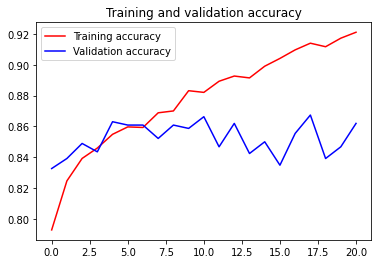

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = results4.history['accuracy']
val_acc = results4.history['val_accuracy']
loss = results4.history['loss']
val_loss = results4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

### 5-2) 모델 전체 파라미터 학습

In [47]:
EfficientNetB7_2 = tf.keras.applications.EfficientNetB7(
                              include_top = False,
                              weights = "imagenet",
                              input_tensor = None,
                              input_shape = (256, 256, 3),
                              )

In [48]:
# EfficientNetB7 레이어들의 파라미터를 학습하도록 설정
for layer in EfficientNetB7_2.layers:
    layer.trainable = True # True = 내가 집어 넣어준 데이터에 맞게 추가 학습한다.

In [49]:
# 모델에 출력층을 생성해준다.
x = EfficientNetB7_2.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions_2 = Dense(4, activation='softmax')(x) # 출력층을 설계한다.
EfficientNetB7_model2 = Model(EfficientNetB7_2.input, predictions_2)

In [50]:
EfficientNetB7_model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_4 (Normalization  (None, 256, 256, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

In [51]:
# 모델 컴파일
EfficientNetB7_model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

* Batch size가 32면 RAM이 터져버린다.....

In [53]:
# 이미지 파일들 불러오기
Dataset_directory = '/content/drive/MyDrive/Curated X-Ray Dataset'

train2 = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory, # 경로 넣어주면 된다.
        labels = "inferred", # 레이블은 디렉토리 구조에서 생성됨
        label_mode = "int", # 레이블이 정수로 인코딩됨을 의미
        class_names = {'COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral'}, #레이블은 이미지 파일 경로의 영숫자 순서에 따라 정렬되어야 한다
        color_mode = "rgb", # "grayscale", "rgb", "rgba" 중 하나
        batch_size = 16, # 데이터 배치의 크기입니다. 기본값: 32
        image_size = (256, 256), # 디스크에서 읽은 후 이미지 크기를 조정할 크기
        shuffle = True, # 데이터를 섞을지 여부. False로 설정하면 데이터를 영숫자 순서로 정렬
        seed = 42, # 셔플 및 변환을 위한 선택적 임의 시드
        validation_split = 0.1, # 0과 1 사이의 선택적 부동 소수점, 유효성 검사를 위해 데이터의 일부 나누기
        subset = 'training', # "training", "validation" → validation_split가 설정된 경우에만 사용
        interpolation = "bilinear", # 문자열, 이미지 크기를 조정할 때 사용되는 보간 방법, bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, 를 지원
        follow_links = False, # 심볼릭 링크가 가리키는 하위 디렉토리를 방문할지 여부
        crop_to_aspect_ratio = False, # True이면 가로 세로 비율 왜곡 없이 이미지 크기를 조정
)

test2 = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory, # 경로 넣어주면 된다.
        labels = "inferred", # 레이블은 디렉토리 구조에서 생성됨
        label_mode = "int", # 레이블이 정수로 인코딩됨을 의미
        class_names = {'COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral'}, #레이블은 이미지 파일 경로의 영숫자 순서에 따라 정렬되어야 한다
        color_mode = "rgb", # "grayscale", "rgb", "rgba" 중 하나
        batch_size = 16, # 데이터 배치의 크기입니다. 기본값: 32
        image_size = (256, 256), # 디스크에서 읽은 후 이미지 크기를 조정할 크기
        shuffle = True, # 데이터를 섞을지 여부. False로 설정하면 데이터를 영숫자 순서로 정렬
        seed = 42, # 셔플 및 변환을 위한 선택적 임의 시드
        validation_split = 0.1, # 0과 1 사이의 선택적 부동 소수점, 유효성 검사를 위해 데이터의 일부 나누기
        subset = 'validation', # "training", "validation" → validation_split가 설정된 경우에만 사용
        interpolation = "bilinear", # 문자열, 이미지 크기를 조정할 때 사용되는 보간 방법, bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, 를 지원
        follow_links = False, # 심볼릭 링크가 가리키는 하위 디렉토리를 방문할지 여부
        crop_to_aspect_ratio = False, # True이면 가로 세로 비율 왜곡 없이 이미지 크기를 조정
)

Found 9208 files belonging to 4 classes.
Using 8288 files for training.
Found 9208 files belonging to 4 classes.
Using 920 files for validation.


In [ ]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath5 = "EfficientNetB7_model2_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath5,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 16
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results5 = EfficientNetB7_model2.fit(train2,
                                    batch_size = batch_size,
                                    epochs = epochs_max,
                                    verbose = 1,
                                    validation_data = test2,
                                    callbacks = [early_stop, save_best])

Epoch 1/50
518/518 [==============================] - ETA: 0s - loss: 0.5685 - accuracy: 0.7803
Epoch 1: val_loss improved from inf to 0.53077, saving model to EfficientNetB7_model2_best.hdf5
518/518 [==============================] - 1078s 2s/step - loss: 0.5685 - accuracy: 0.7803 - val_loss: 0.5308 - val_accuracy: 0.7804
Epoch 2/50
518/518 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.8285
Epoch 2: val_loss improved from 0.53077 to 0.38488, saving model to EfficientNetB7_model2_best.hdf5
518/518 [==============================] - 411s 793ms/step - loss: 0.4147 - accuracy: 0.8285 - val_loss: 0.3849 - val_accuracy: 0.8554
Epoch 3/50
518/518 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8498
Epoch 3: val_loss did not improve from 0.38488
518/518 [==============================] - 410s 791ms/step - loss: 0.3662 - accuracy: 0.8498 - val_loss: 0.4314 - val_accuracy: 0.8293
Epoch 4/50
518/518 [==============================] - ETA: 0s - lo

In [ ]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = EfficientNetB7_model2.evaluate(test2, verbose = 1)

29/29 [==============================] - 10s 304ms/step - loss: 0.4267 - accuracy: 0.9054


In [ ]:
EfficientNetB7_model2.load_weights(checkpoint_filepath5)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = EfficientNetB7_model2.evaluate(test2, verbose = 1)

58/58 [==============================] - 10s 158ms/step - loss: 0.3247 - accuracy: 0.8935


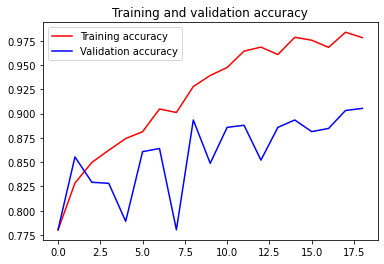

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = results5.history['accuracy']
val_acc = results5.history['val_accuracy']
loss = results5.history['loss']
val_loss = results5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

### 5-3) 분류기 변경1

In [ ]:
EfficientNetB7_3 = tf.keras.applications.EfficientNetB7(
                              include_top = False,
                              weights = "imagenet",
                              input_tensor = None,
                              input_shape = (256, 256, 3),
                              )

In [ ]:
# EfficientNetB7 레이어들의 파라미터를 학습하도록 설정
for layer in EfficientNetB7_3.layers:
    layer.trainable = True # True = 내가 집어 넣어준 데이터에 맞게 추가 학습한다.

In [ ]:
# 모델에 출력층을 생성해준다.
x = EfficientNetB7_3.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions_3 = Dense(4, activation='softmax')(x) # 출력층을 설계한다.
EfficientNetB7_model3 = Model(EfficientNetB7_3.input, predictions_3)

In [ ]:
EfficientNetB7_model3.summary()

In [ ]:
# 모델 컴파일
EfficientNetB7_model3.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath6 = "EfficientNetB7_model3_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 20 → 연속적으로 20번 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 20, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath6,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 16
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results6 = EfficientNetB7_model3.fit(train2,
                                    batch_size = batch_size,
                                    epochs = epochs_max,
                                    verbose = 1,
                                    validation_data = test2,
                                    callbacks = [early_stop, save_best])

Epoch 1/50
518/518 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 0.7426
Epoch 1: val_loss improved from inf to 0.44774, saving model to EfficientNetB7_model3_best.hdf5
518/518 [==============================] - 446s 804ms/step - loss: 0.6414 - accuracy: 0.7426 - val_loss: 0.4477 - val_accuracy: 0.8087
Epoch 2/50
518/518 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.8021
Epoch 2: val_loss improved from 0.44774 to 0.39910, saving model to EfficientNetB7_model3_best.hdf5
518/518 [==============================] - 412s 794ms/step - loss: 0.5027 - accuracy: 0.8021 - val_loss: 0.3991 - val_accuracy: 0.8522
Epoch 3/50
518/518 [==============================] - ETA: 0s - loss: 0.4176 - accuracy: 0.8261
Epoch 3: val_loss did not improve from 0.39910
518/518 [==============================] - 411s 791ms/step - loss: 0.4176 - accuracy: 0.8261 - val_loss: 0.5310 - val_accuracy: 0.7957
Epoch 4/50
518/518 [==============================] - ETA: 0s - 

In [ ]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = EfficientNetB7_model3.evaluate(test2, verbose = 1)

58/58 [==============================] - 10s 158ms/step - loss: 0.6080 - accuracy: 0.8967


In [ ]:
EfficientNetB7_model3.load_weights(checkpoint_filepath6)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = EfficientNetB7_model3.evaluate(test2, verbose = 1)

58/58 [==============================] - 10s 157ms/step - loss: 0.3186 - accuracy: 0.8685


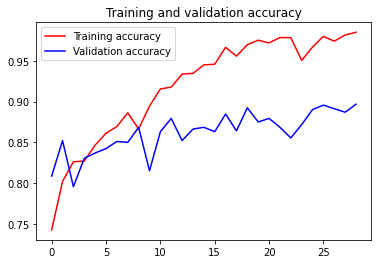

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = results6.history['accuracy']
val_acc = results6.history['val_accuracy']
loss = results6.history['loss']
val_loss = results6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

### 5-4) 분류기 변경 2

In [ ]:
EfficientNetB7_4 = tf.keras.applications.EfficientNetB7(
                              include_top = False,
                              weights = "imagenet",
                              input_tensor = None,
                              input_shape = (256, 256, 3),
                              )

In [ ]:
# EfficientNetB7 레이어들의 파라미터를 학습하도록 설정
for layer in EfficientNetB7_4.layers:
    layer.trainable = True # True = 내가 집어 넣어준 데이터에 맞게 추가 학습한다.

In [ ]:
# 모델에 출력층을 생성해준다.
x = EfficientNetB7_4.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions_4 = Dense(4, activation='softmax')(x) # 출력층을 설계한다.
EfficientNetB7_model4 = Model(EfficientNetB7_4.input, predictions_4)

In [ ]:
EfficientNetB7_model4.summary()

In [ ]:
# 모델 컴파일
EfficientNetB7_model4.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath7 = "EfficientNetB7_model4_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath7,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 16
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results7 = EfficientNetB7_model4.fit(train2,
                                    batch_size = batch_size,
                                    epochs = epochs_max,
                                    verbose = 1,
                                    validation_data = test2,
                                    callbacks = [early_stop, save_best])

Epoch 1/50
518/518 [==============================] - ETA: 0s - loss: 0.6455 - accuracy: 0.7396
Epoch 1: val_loss improved from inf to 0.48463, saving model to EfficientNetB7_model4_best.hdf5
518/518 [==============================] - 481s 805ms/step - loss: 0.6455 - accuracy: 0.7396 - val_loss: 0.4846 - val_accuracy: 0.6924
Epoch 2/50
518/518 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.8048
Epoch 2: val_loss did not improve from 0.48463
518/518 [==============================] - 412s 795ms/step - loss: 0.4738 - accuracy: 0.8048 - val_loss: 0.6980 - val_accuracy: 0.7304
Epoch 3/50
518/518 [==============================] - ETA: 0s - loss: 0.4141 - accuracy: 0.8380
Epoch 3: val_loss improved from 0.48463 to 0.45082, saving model to EfficientNetB7_model4_best.hdf5
518/518 [==============================] - 414s 797ms/step - loss: 0.4141 - accuracy: 0.8380 - val_loss: 0.4508 - val_accuracy: 0.8467
Epoch 4/50
518/518 [==============================] - ETA: 0s - 

In [ ]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = EfficientNetB7_model4.evaluate(test2, verbose = 1)

58/58 [==============================] - 10s 157ms/step - loss: 0.5293 - accuracy: 0.8880


In [ ]:
EfficientNetB7_model4.load_weights(checkpoint_filepath7)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = EfficientNetB7_model4.evaluate(test2, verbose = 1)

58/58 [==============================] - 10s 158ms/step - loss: 0.3801 - accuracy: 0.8598


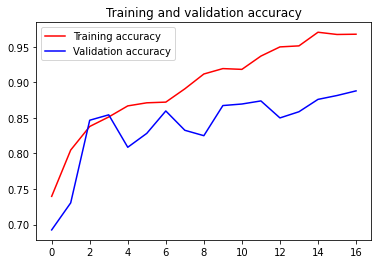

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = results7.history['accuracy']
val_acc = results7.history['val_accuracy']
loss = results7.history['loss']
val_loss = results7.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

### 5-5) 배치 정규화 + 학습률 계획법(Learning rate Scheduling)

In [5]:
EfficientNetB7_5 = tf.keras.applications.EfficientNetB7(
                              include_top = False,
                              weights = "imagenet",
                              input_tensor = None,
                              input_shape = (256, 256, 3),
                              )

258088960/258076736 [==============================] - 2s 0us/step


In [6]:
# EfficientNetB7 레이어들의 파라미터를 학습하도록 설정
for layer in EfficientNetB7_5.layers:
    layer.trainable = True # True = 내가 집어 넣어준 데이터에 맞게 추가 학습한다.

In [7]:
# 모델에 출력층을 생성해준다.
x = EfficientNetB7_5.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, kernel_initializer='uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(512, kernel_initializer='uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(256, kernel_initializer='uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions_5 = Dense(4, activation='softmax')(x) # 출력층을 설계한다.
EfficientNetB7_model5 = Model(EfficientNetB7_5.input, predictions_5)

In [ ]:
EfficientNetB7_model5.summary()

In [9]:
# 모델 컴파일
first_decay_steps = 1000
initial_learning_rate = 0.01
lr_decayed_fn = (
  tf.keras.experimental.CosineDecayRestarts(
      initial_learning_rate,
      first_decay_steps))
EfficientNetB7_model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn)
                              , loss='sparse_categorical_crossentropy'
                              , metrics=['accuracy'])

* Batch size가 16이면 RAM이 터져서 8로 변결한다.

In [55]:
# 이미지 파일들 불러오기
Dataset_directory = '/content/drive/MyDrive/Curated X-Ray Dataset'

train3 = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory, # 경로 넣어주면 된다.
        labels = "inferred", # 레이블은 디렉토리 구조에서 생성됨
        label_mode = "int", # 레이블이 정수로 인코딩됨을 의미
        class_names = {'COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral'}, #레이블은 이미지 파일 경로의 영숫자 순서에 따라 정렬되어야 한다
        color_mode = "rgb", # "grayscale", "rgb", "rgba" 중 하나
        batch_size = 8, # 데이터 배치의 크기입니다. 기본값: 32
        image_size = (256, 256), # 디스크에서 읽은 후 이미지 크기를 조정할 크기
        shuffle = True, # 데이터를 섞을지 여부. False로 설정하면 데이터를 영숫자 순서로 정렬
        seed = 42, # 셔플 및 변환을 위한 선택적 임의 시드
        validation_split = 0.1, # 0과 1 사이의 선택적 부동 소수점, 유효성 검사를 위해 데이터의 일부 나누기
        subset = 'training', # "training", "validation" → validation_split가 설정된 경우에만 사용
        interpolation = "bilinear", # 문자열, 이미지 크기를 조정할 때 사용되는 보간 방법, bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, 를 지원
        follow_links = False, # 심볼릭 링크가 가리키는 하위 디렉토리를 방문할지 여부
        crop_to_aspect_ratio = False, # True이면 가로 세로 비율 왜곡 없이 이미지 크기를 조정
)

test3 = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory, # 경로 넣어주면 된다.
        labels = "inferred", # 레이블은 디렉토리 구조에서 생성됨
        label_mode = "int", # 레이블이 정수로 인코딩됨을 의미
        class_names = {'COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral'}, #레이블은 이미지 파일 경로의 영숫자 순서에 따라 정렬되어야 한다
        color_mode = "rgb", # "grayscale", "rgb", "rgba" 중 하나
        batch_size = 8, # 데이터 배치의 크기입니다. 기본값: 32
        image_size = (256, 256), # 디스크에서 읽은 후 이미지 크기를 조정할 크기
        shuffle = True, # 데이터를 섞을지 여부. False로 설정하면 데이터를 영숫자 순서로 정렬
        seed = 42, # 셔플 및 변환을 위한 선택적 임의 시드
        validation_split = 0.1, # 0과 1 사이의 선택적 부동 소수점, 유효성 검사를 위해 데이터의 일부 나누기
        subset = 'validation', # "training", "validation" → validation_split가 설정된 경우에만 사용
        interpolation = "bilinear", # 문자열, 이미지 크기를 조정할 때 사용되는 보간 방법, bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, 를 지원
        follow_links = False, # 심볼릭 링크가 가리키는 하위 디렉토리를 방문할지 여부
        crop_to_aspect_ratio = False, # True이면 가로 세로 비율 왜곡 없이 이미지 크기를 조정
)

Found 9208 files belonging to 4 classes.
Using 8288 files for training.
Found 9208 files belonging to 4 classes.
Using 920 files for validation.


In [11]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath8 = "EfficientNetB7_model5_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath8,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 8
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results8 = EfficientNetB7_model5.fit(train3,
                                    batch_size = batch_size,
                                    epochs = epochs_max,
                                    verbose = 1,
                                    validation_data = test3,
                                    callbacks = [early_stop, save_best])

Epoch 1/50
1036/1036 [==============================] - ETA: 0s - loss: 1.3690 - accuracy: 0.3814
Epoch 1: val_loss improved from inf to 16.58803, saving model to EfficientNetB7_model5_best.hdf5
1036/1036 [==============================] - 636s 562ms/step - loss: 1.3690 - accuracy: 0.3814 - val_loss: 16.5880 - val_accuracy: 0.4554
Epoch 2/50
1036/1036 [==============================] - ETA: 0s - loss: 1.2922 - accuracy: 0.4087
Epoch 2: val_loss improved from 16.58803 to 1.29273, saving model to EfficientNetB7_model5_best.hdf5
1036/1036 [==============================] - 480s 463ms/step - loss: 1.2922 - accuracy: 0.4087 - val_loss: 1.2927 - val_accuracy: 0.4457
Epoch 3/50
1036/1036 [==============================] - ETA: 0s - loss: 1.1609 - accuracy: 0.5322
Epoch 3: val_loss did not improve from 1.29273
1036/1036 [==============================] - 479s 462ms/step - loss: 1.1609 - accuracy: 0.5322 - val_loss: 29.0254 - val_accuracy: 0.3543
Epoch 4/50
1036/1036 [==========================

In [12]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = EfficientNetB7_model5.evaluate(test3, verbose = 1)

115/115 [==============================] - 12s 97ms/step - loss: 0.5694 - accuracy: 0.7630


In [13]:
EfficientNetB7_model5.load_weights(checkpoint_filepath8)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = EfficientNetB7_model5.evaluate(test3, verbose = 1)

115/115 [==============================] - 12s 98ms/step - loss: 0.3277 - accuracy: 0.8598


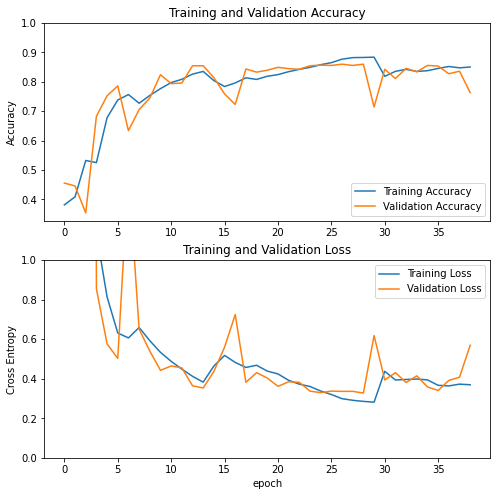

In [15]:
acc = results8.history['accuracy']
val_acc = results8.history['val_accuracy']

loss = results8.history['loss']
val_loss = results8.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 5-6) EfficientNetB7_2에 Dropout 적용

In [25]:
EfficientNetB7_9 = tf.keras.applications.EfficientNetB7(
                              include_top = False,
                              weights = "imagenet",
                              input_tensor = None,
                              input_shape = (256, 256, 3),
                              )

In [26]:
# EfficientNetB7 레이어들의 파라미터를 학습하도록 설정
for layer in EfficientNetB7_9.layers:
    layer.trainable = True # True = 내가 집어 넣어준 데이터에 맞게 추가 학습한다.

In [27]:
# 모델에 출력층을 생성해준다.
x = EfficientNetB7_9.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions_9 = Dense(4, activation='softmax')(x) # 출력층을 설계한다.
EfficientNetB7_model9 = Model(EfficientNetB7_9.input, predictions_9)

In [28]:
EfficientNetB7_model9.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 256, 256, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [29]:
# 모델 컴파일
EfficientNetB7_model9.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [30]:
# 이미지 파일들 불러오기
Dataset_directory = '/content/drive/MyDrive/Curated X-Ray Dataset'

train2 = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory, # 경로 넣어주면 된다.
        labels = "inferred", # 레이블은 디렉토리 구조에서 생성됨
        label_mode = 'categorical', # 레이블이 범주형 벡터로 인코딩됨을 의미
        class_names = {'COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral'}, #레이블은 이미지 파일 경로의 영숫자 순서에 따라 정렬되어야 한다
        color_mode = "rgb", # "grayscale", "rgb", "rgba" 중 하나
        batch_size = 16, # 데이터 배치의 크기입니다. 기본값: 32
        image_size = (256, 256), # 디스크에서 읽은 후 이미지 크기를 조정할 크기
        shuffle = True, # 데이터를 섞을지 여부. False로 설정하면 데이터를 영숫자 순서로 정렬
        seed = 42, # 셔플 및 변환을 위한 선택적 임의 시드
        validation_split = 0.1, # 0과 1 사이의 선택적 부동 소수점, 유효성 검사를 위해 데이터의 일부 나누기
        subset = 'training', # "training", "validation" → validation_split가 설정된 경우에만 사용
        interpolation = "bilinear", # 문자열, 이미지 크기를 조정할 때 사용되는 보간 방법, bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, 를 지원
        follow_links = False, # 심볼릭 링크가 가리키는 하위 디렉토리를 방문할지 여부
        crop_to_aspect_ratio = False, # True이면 가로 세로 비율 왜곡 없이 이미지 크기를 조정
)

test2 = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory, # 경로 넣어주면 된다.
        labels = "inferred", # 레이블은 디렉토리 구조에서 생성됨
        label_mode = 'categorical', # 레이블이 범주형 벡터로 인코딩됨을 의미
        class_names = {'COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral'}, #레이블은 이미지 파일 경로의 영숫자 순서에 따라 정렬되어야 한다
        color_mode = "rgb", # "grayscale", "rgb", "rgba" 중 하나
        batch_size = 16, # 데이터 배치의 크기입니다. 기본값: 32
        image_size = (256, 256), # 디스크에서 읽은 후 이미지 크기를 조정할 크기
        shuffle = True, # 데이터를 섞을지 여부. False로 설정하면 데이터를 영숫자 순서로 정렬
        seed = 42, # 셔플 및 변환을 위한 선택적 임의 시드
        validation_split = 0.1, # 0과 1 사이의 선택적 부동 소수점, 유효성 검사를 위해 데이터의 일부 나누기
        subset = 'validation', # "training", "validation" → validation_split가 설정된 경우에만 사용
        interpolation = "bilinear", # 문자열, 이미지 크기를 조정할 때 사용되는 보간 방법, bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, 를 지원
        follow_links = False, # 심볼릭 링크가 가리키는 하위 디렉토리를 방문할지 여부
        crop_to_aspect_ratio = False, # True이면 가로 세로 비율 왜곡 없이 이미지 크기를 조정
)

Found 9208 files belonging to 4 classes.
Using 8288 files for training.
Found 9208 files belonging to 4 classes.
Using 920 files for validation.


In [31]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath9 = "EfficientNetB7_model9_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath9,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 16
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results9 = EfficientNetB7_model9.fit(train2,
                                    batch_size = batch_size,
                                    epochs = epochs_max,
                                    verbose = 1,
                                    validation_data = test2,
                                    callbacks = [early_stop, save_best])

Epoch 1/50
518/518 [==============================] - ETA: 0s - loss: 0.5943 - accuracy: 0.7668
Epoch 1: val_loss improved from inf to 0.37730, saving model to EfficientNetB7_model9_best.hdf5
518/518 [==============================] - 461s 814ms/step - loss: 0.5943 - accuracy: 0.7668 - val_loss: 0.3773 - val_accuracy: 0.8598
Epoch 2/50
518/518 [==============================] - ETA: 0s - loss: 0.4275 - accuracy: 0.8290
Epoch 2: val_loss did not improve from 0.37730
518/518 [==============================] - 417s 802ms/step - loss: 0.4275 - accuracy: 0.8290 - val_loss: 0.6160 - val_accuracy: 0.8272
Epoch 3/50
518/518 [==============================] - ETA: 0s - loss: 0.4154 - accuracy: 0.8319
Epoch 3: val_loss did not improve from 0.37730
518/518 [==============================] - 416s 801ms/step - loss: 0.4154 - accuracy: 0.8319 - val_loss: 0.4931 - val_accuracy: 0.8109
Epoch 4/50
518/518 [==============================] - ETA: 0s - loss: 0.3706 - accuracy: 0.8510
Epoch 4: val_loss did

In [32]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = EfficientNetB7_model9.evaluate(test2, verbose = 1)

58/58 [==============================] - 10s 160ms/step - loss: 0.6151 - accuracy: 0.8250


In [34]:
EfficientNetB7_model9.load_weights(checkpoint_filepath9)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = EfficientNetB7_model9.evaluate(test2, verbose = 1)

58/58 [==============================] - 10s 160ms/step - loss: 0.3035 - accuracy: 0.8804


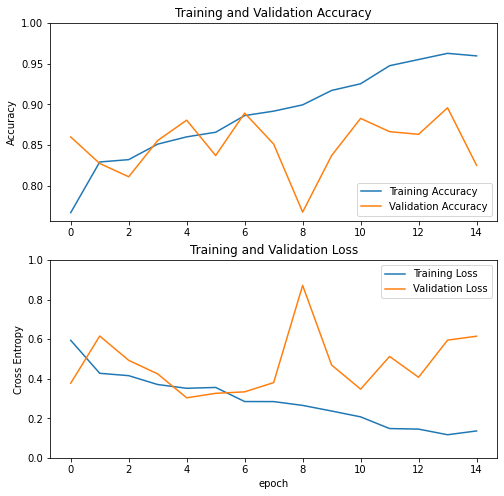

In [35]:
acc = results9.history['accuracy']
val_acc = results9.history['val_accuracy']

loss = results9.history['loss']
val_loss = results9.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 6. Grad-CAM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

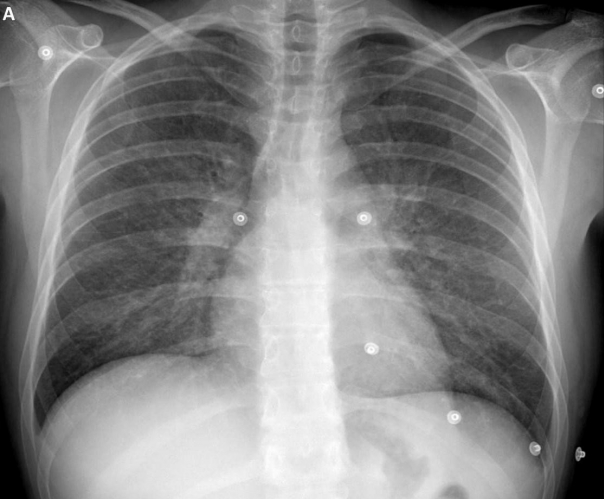

In [ ]:
# The local path to our target image
img_path = '/content/drive/MyDrive/Curated X-Ray Dataset/COVID-19/COVID-19 (1).jpg'

display(Image(img_path))

In [ ]:
# https://github.com/gkeechin/vizgradcam/blob/main/gradcam.py

import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array

def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"
    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis=0)
    #predict
    prediction = model.predict(img)
    #prediction index
    prediction_idx = np.argmax(prediction)
    #STEP 2: Create new model
    #specify last convolutional layer
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)
    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map  
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]
    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)
    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]
    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))
    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(), 
                                (original_img.shape[1], 
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)
    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)
    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

### 6-1) InceptionResNetV2에 Grad-CAM 적용

In [ ]:
inception_resnet_model.load_weights('/content/drive/MyDrive/Curated X-Ray Dataset/inception_resnet_model_best.hdf5')

In [ ]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath3 = "inception_resnet_model_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath3,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results3 = inception_resnet_model.fit(train,
                                      batch_size = batch_size,
                                      epochs = epochs_max,
                                      verbose = 1,
                                      validation_data = test,
                                      callbacks = [early_stop, save_best])

Epoch 1/50
259/259 [==============================] - ETA: 0s - loss: 0.5238 - accuracy: 0.8152
Epoch 1: val_loss improved from inf to 7.67058, saving model to inception_resnet_model_best.hdf5
259/259 [==============================] - 229s 796ms/step - loss: 0.5238 - accuracy: 0.8152 - val_loss: 7.6706 - val_accuracy: 0.3239
Epoch 2/50
259/259 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.9383
Epoch 2: val_loss improved from 7.67058 to 1.48004, saving model to inception_resnet_model_best.hdf5
259/259 [==============================] - 211s 805ms/step - loss: 0.1704 - accuracy: 0.9383 - val_loss: 1.4800 - val_accuracy: 0.6880
Epoch 3/50
259/259 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.9539
Epoch 3: val_loss improved from 1.48004 to 1.13824, saving model to inception_resnet_model_best.hdf5
259/259 [==============================] - 213s 811ms/step - loss: 0.1305 - accuracy: 0.9539 - val_loss: 1.1382 - val_accuracy: 0.7185
Epoch 4/

In [ ]:
inception_resnet_model.load_weights('/content/inception_resnet_model_best.hdf5')

In [ ]:
# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = inception_resnet_model.evaluate(test, verbose = 1)

29/29 [==============================] - 381s 11s/step - loss: 0.3073 - accuracy: 0.8880


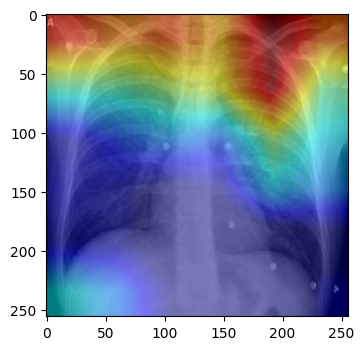

In [ ]:
#load image
img = cv2.imread(img_path)
test_img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

#apply function
VizGradCAM(inception_resnet_model, img_to_array(test_img), plot_results=True)

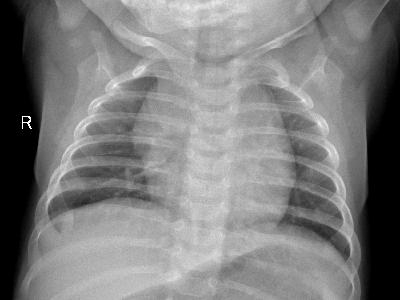

In [ ]:
# The local path to our target image
img_path_Normal = '/content/drive/MyDrive/Curated X-Ray Dataset/Normal/Normal (1).jpg'

display(Image(img_path_Normal))

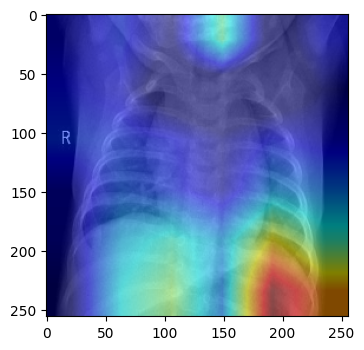

In [ ]:
#load image
img_Normal = cv2.imread(img_path_Normal)
test_img_Normal = cv2.resize(img_Normal, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

#apply function
VizGradCAM(inception_resnet_model, img_to_array(test_img_Normal), plot_results=True)

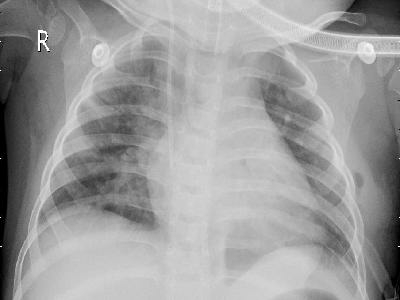

In [ ]:
# The local path to our target image
img_path_Bacterial = '/content/drive/MyDrive/Curated X-Ray Dataset/Pneumonia-Bacterial/Pneumonia-Bacterial (1).jpg'

display(Image(img_path_Bacterial))

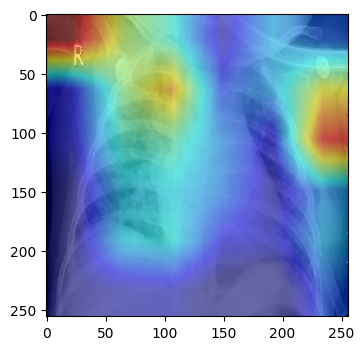

In [ ]:
#load image
img_Bacterial = cv2.imread(img_path_Bacterial)
test_img_Bacterial = cv2.resize(img_Bacterial, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

#apply function
VizGradCAM(inception_resnet_model, img_to_array(test_img_Bacterial), plot_results=True)

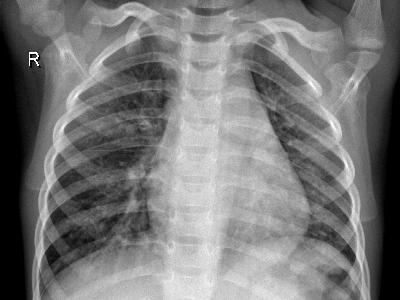

In [ ]:
# The local path to our target image
img_path_Viral = '/content/drive/MyDrive/Curated X-Ray Dataset/Pneumonia-Viral/Pneumonia-Viral (1).jpg'

display(Image(img_path_Viral))

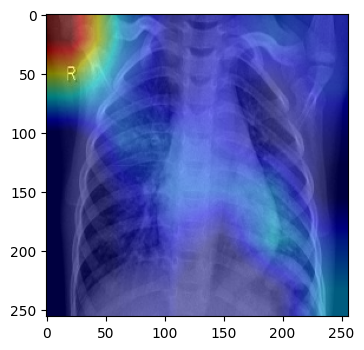

In [ ]:
#load image
img_Viral = cv2.imread(img_path_Viral)
test_img_Viral = cv2.resize(img_Viral, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

#apply function
VizGradCAM(inception_resnet_model, img_to_array(test_img_Viral), plot_results=True)

### 6-2) EfficientNetB7 + 배치 정규화에 Grad-CAM 적용

In [74]:
EfficientNetB7_2 = tf.keras.applications.EfficientNetB7(
                              include_top = False,
                              weights = "imagenet",
                              input_tensor = None,
                              input_shape = (256, 256, 3),
                              drop_connect_rate = 0.3
                              )

In [75]:
# EfficientNetB7 레이어들의 파라미터를 학습하도록 설정
for layer in EfficientNetB7_2.layers:
    layer.trainable = True # True = 내가 집어 넣어준 데이터에 맞게 추가 학습한다.

In [76]:
# 모델에 출력층을 생성해준다.
x = EfficientNetB7_2.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# 다중 분류 모델을 만들어준다.
x = Dense(1024, kernel_initializer='uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(512, kernel_initializer='uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(256, kernel_initializer='uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions_2 = Dense(4, activation='softmax')(x) # 출력층을 설계한다.
EfficientNetB7_model2 = Model(EfficientNetB7_2.input, predictions_2)

In [77]:
# 모델 컴파일
EfficientNetB7_model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath5 = "EfficientNetB7_model2_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath5,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 8
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results5 = EfficientNetB7_model2.fit(train3,
                                    batch_size = batch_size,
                                    epochs = epochs_max,
                                    verbose = 1,
                                    validation_data = test3,
                                    callbacks = [early_stop, save_best])

Epoch 1/50
1036/1036 [==============================] - ETA: 0s - loss: 0.7098 - accuracy: 0.7232
Epoch 1: val_loss improved from inf to 7.36804, saving model to EfficientNetB7_model2_best.hdf5
1036/1036 [==============================] - 520s 467ms/step - loss: 0.7098 - accuracy: 0.7232 - val_loss: 7.3680 - val_accuracy: 0.5250
Epoch 2/50
1036/1036 [==============================] - ETA: 0s - loss: 0.5583 - accuracy: 0.7822
Epoch 2: val_loss improved from 7.36804 to 0.49181, saving model to EfficientNetB7_model2_best.hdf5
1036/1036 [==============================] - 477s 460ms/step - loss: 0.5583 - accuracy: 0.7822 - val_loss: 0.4918 - val_accuracy: 0.8098
Epoch 3/50
 187/1036 [====>.........................] - ETA: 6:21 - loss: 0.5167 - accuracy: 0.8008

In [64]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = EfficientNetB7_model2.evaluate(test3, verbose = 1)

115/115 [==============================] - 12s 97ms/step - loss: 0.4730 - accuracy: 0.8880


In [68]:
EfficientNetB7_model2.load_weights(checkpoint_filepath5)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = EfficientNetB7_model2.evaluate(test2, verbose = 1)

58/58 [==============================] - 11s 159ms/step - loss: 0.3416 - accuracy: 0.8750


In [ ]:
# Model 저장
EfficientNetB7_model2.save('EfficientNetB7_model2.h5')

In [ ]:
# Model 불러오기
EfficientNetB7_model2.load_model('EfficientNetB7_model2.h5')

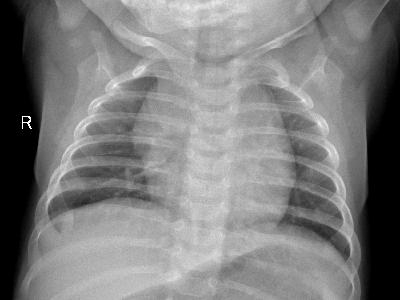

In [ ]:
# The local path to our target image
img_path_Normal = '/content/drive/MyDrive/Curated X-Ray Dataset/Normal/Normal (1).jpg'

display(Image(img_path_Normal))

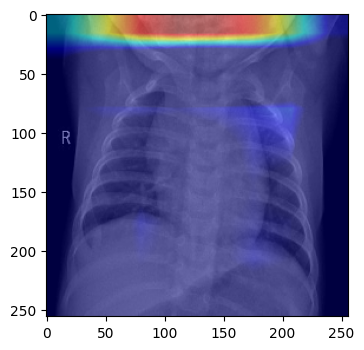

In [ ]:
#load image
img_Normal = cv2.imread(img_path_Normal)
test_img_Normal = cv2.resize(img_Normal, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

#apply function
VizGradCAM(EfficientNetB7_model2, img_to_array(test_img_Normal), plot_results=True)

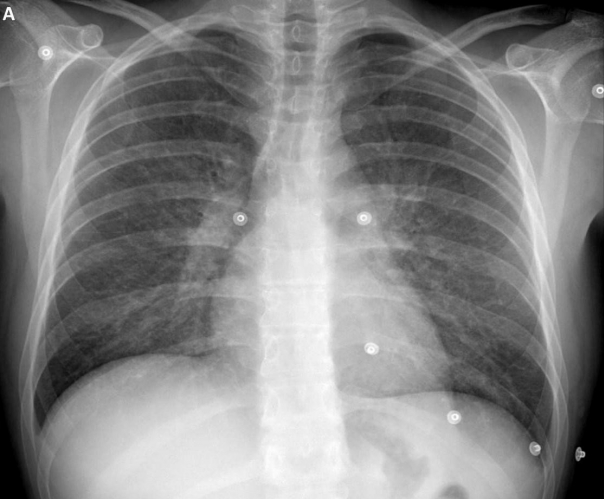

In [ ]:
# The local path to our target image
img_path_COVID19 = '/content/drive/MyDrive/Curated X-Ray Dataset/COVID-19/COVID-19 (1).jpg'

display(Image(img_path_COVID19))

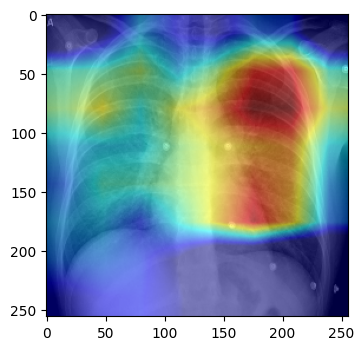

In [ ]:
#load image
img_COVID19 = cv2.imread(img_path_COVID19)
test_img_COVID19 = cv2.resize(img_COVID19, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

#apply function
VizGradCAM(EfficientNetB7_model2, img_to_array(test_img_COVID19), plot_results=True)

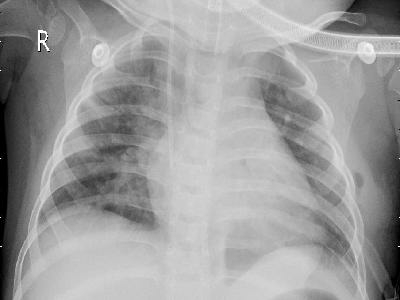

In [ ]:
# The local path to our target image
img_path_Bacterial = '/content/drive/MyDrive/Curated X-Ray Dataset/Pneumonia-Bacterial/Pneumonia-Bacterial (1).jpg'

display(Image(img_path_Bacterial))

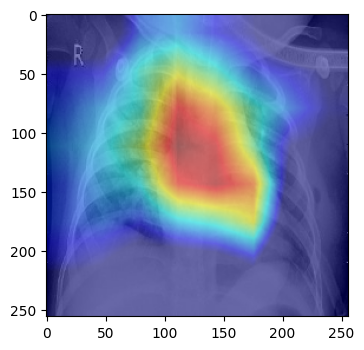

In [ ]:
#load image
img_Bacterial = cv2.imread(img_path_Bacterial)
test_img_Bacterial = cv2.resize(img_Bacterial, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

#apply function
VizGradCAM(EfficientNetB7_model2, img_to_array(test_img_Bacterial), plot_results=True)

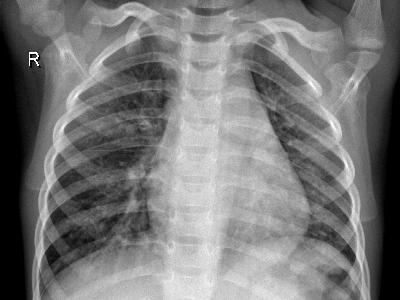

In [ ]:
# The local path to our target image
img_path_Viral = '/content/drive/MyDrive/Curated X-Ray Dataset/Pneumonia-Viral/Pneumonia-Viral (1).jpg'

display(Image(img_path_Viral))

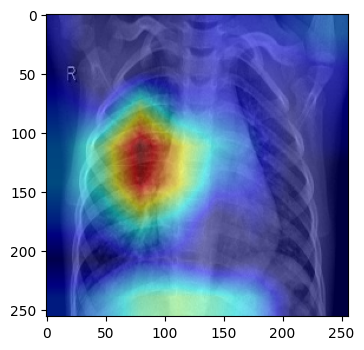

In [ ]:
#load image
img_Viral = cv2.imread(img_path_Viral)
test_img_Viral = cv2.resize(img_Viral, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

#apply function
VizGradCAM(EfficientNetB7_model2, img_to_array(test_img_Viral), plot_results=True)

## 모델을 이용한 예측 결과

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Curated X-Ray Dataset/Normal/Normal (1).jpg", target_size=(256,256)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)

In [ ]:
probs = model.predict(img)

In [ ]:
i = tf.argmax(probs, axis=-1).numpy().tolist()[0]
print(i)

In [ ]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
np.set_printoptions(precision=2)

#Making prediction
y_pred = model.predict_classes(x_test)
y_true = np.argmax(y_test, axis=1)

#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

class_names=['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names,title = 'Confusion matrix, without normalization')

In [ ]:
# Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')